In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import backbone.Custom as cust
import backbone.VISUAL as viz
import importlib
import matplotlib.pyplot as plt
import backbone.AstroMLmod as AstroMLmod
import numpy as np
import backbone.TwoNN as TwoNN
import time
import h5py
import skdim
import pickle
from sklearn.metrics import davies_bouldin_score

    
importlib.reload(cust)
importlib.reload(viz)
importlib.reload(AstroMLmod)


def get_data_loaders(Dir = "some/directory", batch_size = 32):

    #obtain  data from a folder a of images
    dataset = torchvision.datasets.ImageFolder(Dir)
    names = [name[0].split('/')[-1] for name in dataset.imgs]
    transformed_dataset = cust.Custom_labelled(dataset,names =names,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.10)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

def perturb_list_by_swapping(lst, percentage=5):
    num_swaps = max(1, int(len(lst) * (percentage / 100)))  # Ensure at least one swap
    perturbed_lst = lst[:]  # Copy the list to avoid modifying the original

    for _ in range(num_swaps):
        i, j = random.sample(range(len(lst)), 2)  # Pick two distinct indices
        perturbed_lst[i], perturbed_lst[j] = perturbed_lst[j], perturbed_lst[i]  # Swap them
    
    return perturbed_lst


def galaxyzoo10(batch_size = 256):

    # To get the images and labels from file
    with h5py.File('Galaxy10_DECals.h5', 'r') as F:
        images = np.array(F['images'])
        labels = np.array(F['ans'])
        ids = np.array(F['ra'])
    
    # To convert the labels to categorical 10 classes

    # To convert to desirable type
    labels = labels.astype(np.int64)
    #labels = perturb_list_by_swapping(labels, percentage=5)
    images = images.astype(np.float16)
    

    transformed_dataset = cust.ArrayDataset(images = images,labels =labels,names = ids,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, train_size = 0.7,val_split=0.3)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)

    return train_loader, test_loader
    
def evaluate(model, train_loader,test_loader, device):
            
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    print(f'Train Accuracy: {100 * correct / total:.2f}%')
    train_accuracy = 100 * correct / total

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    test_accuracy = 100 * correct / total
    torch.cuda.empty_cache()
    #evaluate(model, train_loader, test_loader, device)


    return train_accuracy, test_accuracy




def train_resnet(num_epochs=100, learning_rate=0.0005, Dir ="galaxy_zoo_class_new", batch_size=64, device='cuda'):

    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))
    plt.rcParams.update({'font.size': 20}) 


    train_loader, test_loader = galaxyzoo10(batch_size = batch_size)
    
    model = models.efficientnet_b0(weights = "IMAGENET1K_V1")

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #get_representations(model = model,loader = train_loader, batch_size = batch_size, epoch = 0,device  = device)
    model.classifier[1]= nn.Linear(model.classifier[1].in_features, 10) 
    #randomize the weights of the newly added sub-layers
    model.classifier[1].weight.data.normal_(0,0.01)
    model = model.to(device)

    intrinsic_dimension = []
    validation_accuracy = []
    train_accuracy = []
    norm_scores = []
    chi_scores = []
    davies_array = []

    #Obtain train and test accuracies
    
    train, val = evaluate(model, train_loader, test_loader, device)

    #get representatations
    
    test_representations, test_labels = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)


    val_flat = viz.pca(test_representations,n_components = 3)

    davies =  davies_bouldin_score(val_flat, test_labels)
    davies_array.append(davies)

    

    
    
    #conpute the id_score
    #id_score,std = AstroMLmod.id_score(test_representations)
    
   # intrinsic_dimension.append((id_score,std))
    
    validation_accuracy.append(val)
    train_accuracy.append(train)
    #Faltten the manifold
    epoch = 0
    #val_flat = viz.umap(test_representations,scatter = True,name = "UMAP", dim = 2, min_dist = 0.6, n_neighbors = 50,alpha = 0.2)
    
    """
    pkl_filename = "plots/val_flat"+str(epoch)+".csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(val_flat,file)

    #davies_flat =  davies_bouldin_score(val_flat, test_labels)
    #davies_array.append(davies_flat)
    #print("davies flat ", davies_flat)
    """

    
    chi_score, norm_score = AstroMLmod.correlate_and_plot(val_flat,
                                                                      min_dist = 0.0,
                                                                      max_dist =1.5,
                                                                      label = "Correlation on flat manifold for epoch:"+str(epoch),
                                                                    fig_name = "plots/2PCR@Epoch: "+str(epoch),
                                                                  representations = test_representations
                                                             )


    #Append to list for later

    norm_scores.append(norm_score)
    chi_scores.append(chi_score)


        
    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))


    
    for epoch in range(1,num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, names in train_loader:
            
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        model.eval()
        
        train, val =  evaluate(model, train_loader, test_loader, device)
        #save classification layer for next epoch
        
        class_layer = model.classifier
        
        
        test_representations, test_labels = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)
        
        
        

        val_flat = viz.pca(test_representations,n_components = 3)

        davies =  davies_bouldin_score(val_flat, test_labels)

    
        #print("Davies boulding score: ", davies)
        #conpute the id_score
        #id_score,std = AstroMLmod.id_score(test_representations)
    
        #intrinsic_dimension.append((id_score,std))
        #y, yerr = zip(*intrinsic_dimension)

        
        #Faltten the manifold
        #val_flat = viz.umap(test_representations,scatter = True,name = "UMAP", dim = 2, min_dist = 0.6, n_neighbors = 50,alpha = 0.2)
        #val_flat = viz.pca(test_representations,n_components = 2)
        """
        davies_flat =  davies_bouldin_score(val_flat, test_labels)
        pkl_filename = "plots/val_flat"+str(epoch)+".csv"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(val_flat,file)
        """

                
        davies_array.append(davies)
        print(davies_array)
        plt.plot(davies_array)
        plt.show()


        #print("davies flat ", davies_flat)

        chi_score, norm_score = AstroMLmod.correlate_and_plot(val_flat,
                                                                      min_dist = 0.0,
                                                                      max_dist =1.5,
                                                                      label = "Correlation on flat manifold for epoch:"+str(epoch),
                                                                      fig_name = "plots/2PCR@Epoch: "+str(epoch),
                                                                     representations = test_representations)


        norm_scores.append(norm_score)
        chi_scores.append(chi_score)




        validation_accuracy.append(val)
        train_accuracy.append(train)
 

        #model.fc = nn.Linear(512, 10) 
        model.classifier = class_layer
        #model.fc = model.fc.to(device)
        
        
        x = np.arange(epoch+1)
        plt.plot([a for a,b in norm_scores], label = "Chi score", color = "blue")
        #plt.fill_between(x, y - yerr, y + yerr, color="blue", alpha=0.3)
        plt.show()
           
        #plt.errorbar(x, y, yerr=yerr, fmt='o', color = "blue", capsize=1)


        plt.plot([100-a for a in validation_accuracy], label = "validation error")
        plt.plot([100-a for a in train_accuracy], label = "Train error")
        plt.xlabel("Epoch")
        plt.legend(loc="upper right")
        plt.show()
        
        if epoch%10 ==0:
            pkl_filename = "davies_chi_scores.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(chi_scores,file)
                
            pkl_filename = "davies_norm_scores.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(norm_scores,file)
                
            pkl_filename = "davies_chi_validation.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(validation_accuracy,file)
                
            pkl_filename = "davies_chi_train.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(train_accuracy,file) 



if __name__ == "__main__":
    train_resnet()

/users/koketso/.venv/deepclustering3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1920x1440 with 0 Axes>

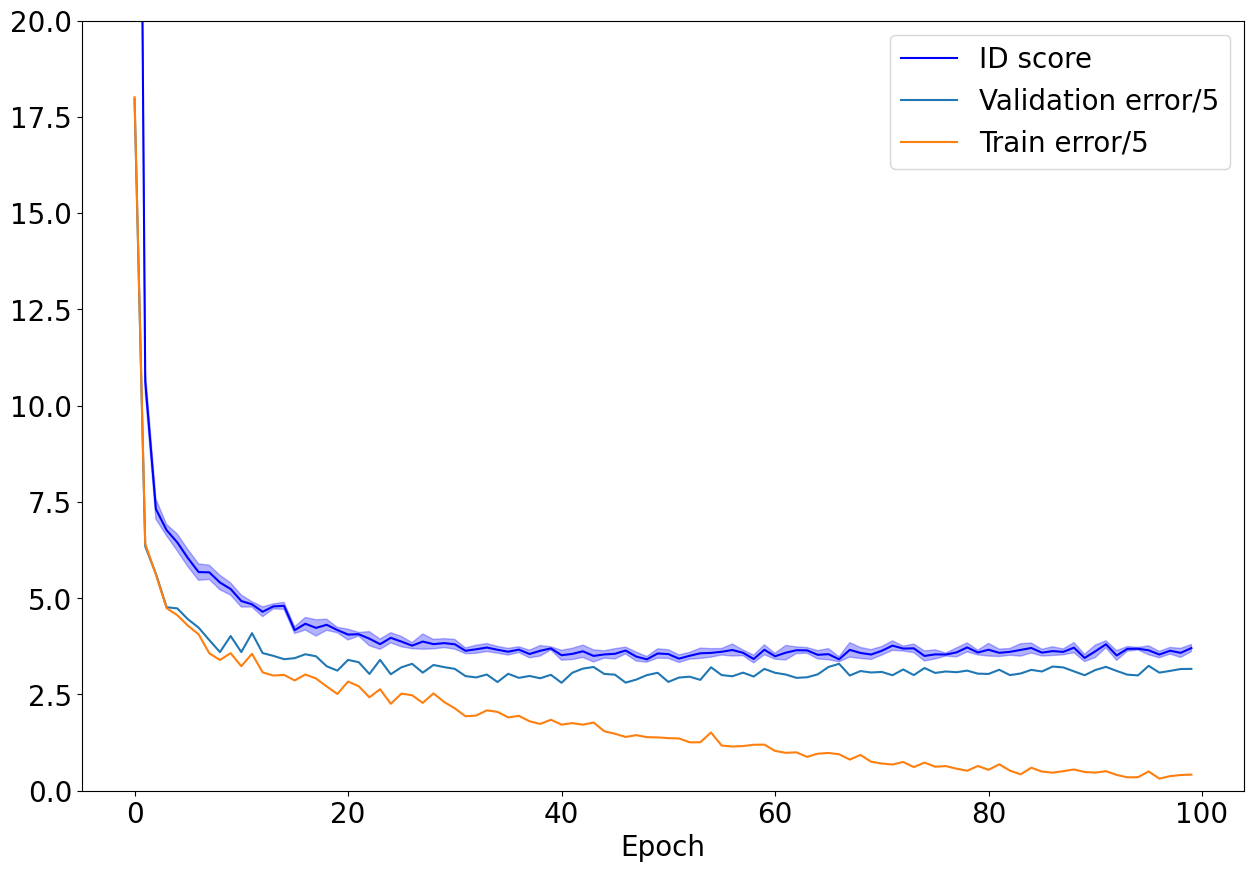

In [25]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

pkl_filename = "intrinsic_dimension.csv"
with open(pkl_filename, 'rb') as file:
    i_d= pickle.load(file)
        
pkl_filename = "validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_accuracy = pickle.load(file) 

pkl_filename = "train.csv"
with open(pkl_filename, 'rb') as file:
    train_accuracy = pickle.load(file) 

y,yerr = zip(*i_d)
x = range(len(y))
yerr = np.array(yerr)
y = np.array(y)
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.plot(y, label = "ID score", color = "blue")
plt.fill_between(x, y - yerr, y + yerr, color="blue", alpha=0.3)

plt.plot([(100-a)/5 for a in validation_accuracy], label = "Validation error/5")
plt.plot([(100-a)/5 for a in train_accuracy], label = "Train error/5")
plt.xlabel("Epoch")
plt.ylim(0,20)

plt.legend(loc="upper right")
plt.show()

/users/koketso/.venv/deepclustering3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-04 13:33:31.844360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756985611.869177 3911612 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756985611.876911 3911612 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-04 13:33:31.905480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.


8.38388451382149
Computing background and RR distributions: will be slower


<Figure size 640x480 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

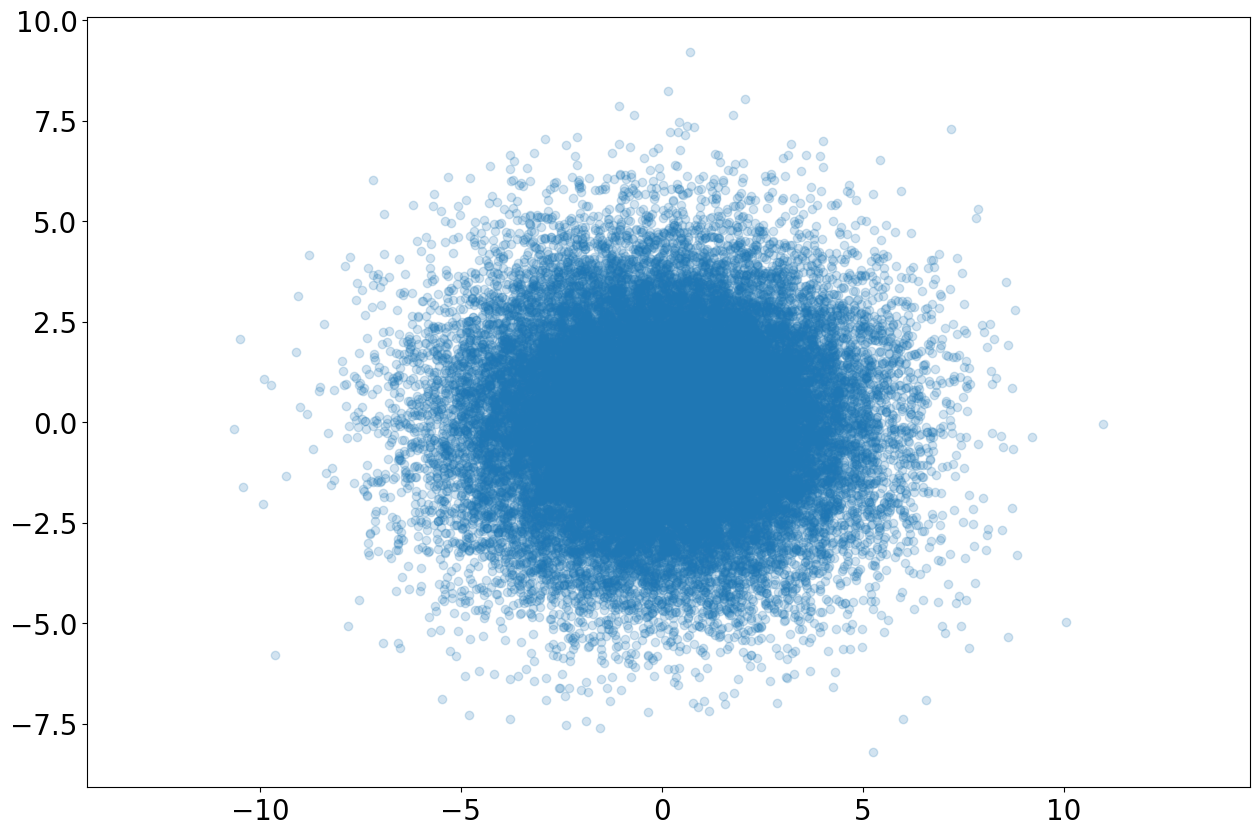

99
Repley's K:  (90.93749596159574, 0.006016585066594109)


<Figure size 1920x1440 with 0 Axes>

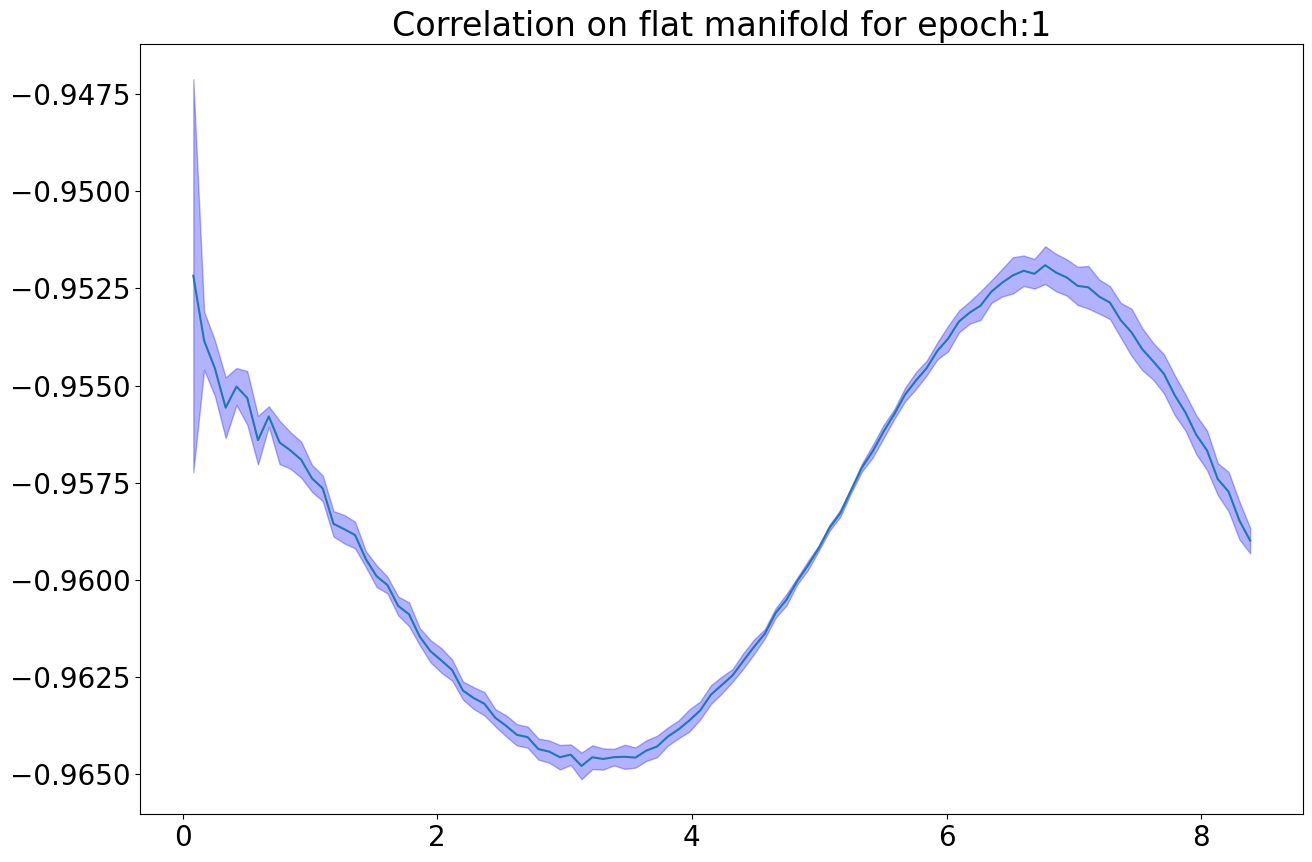

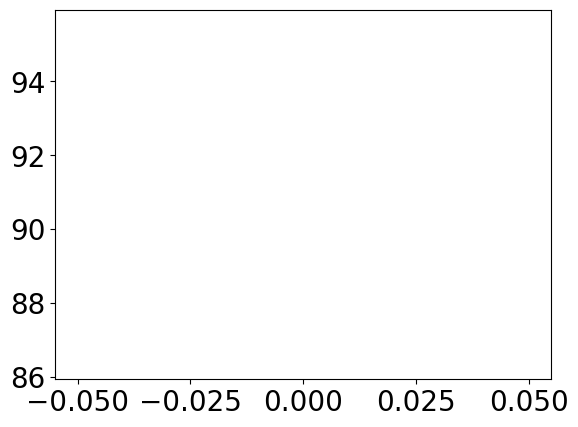

7.089816537236526
Computing background and RR distributions: will be slower


<Figure size 1920x1440 with 0 Axes>

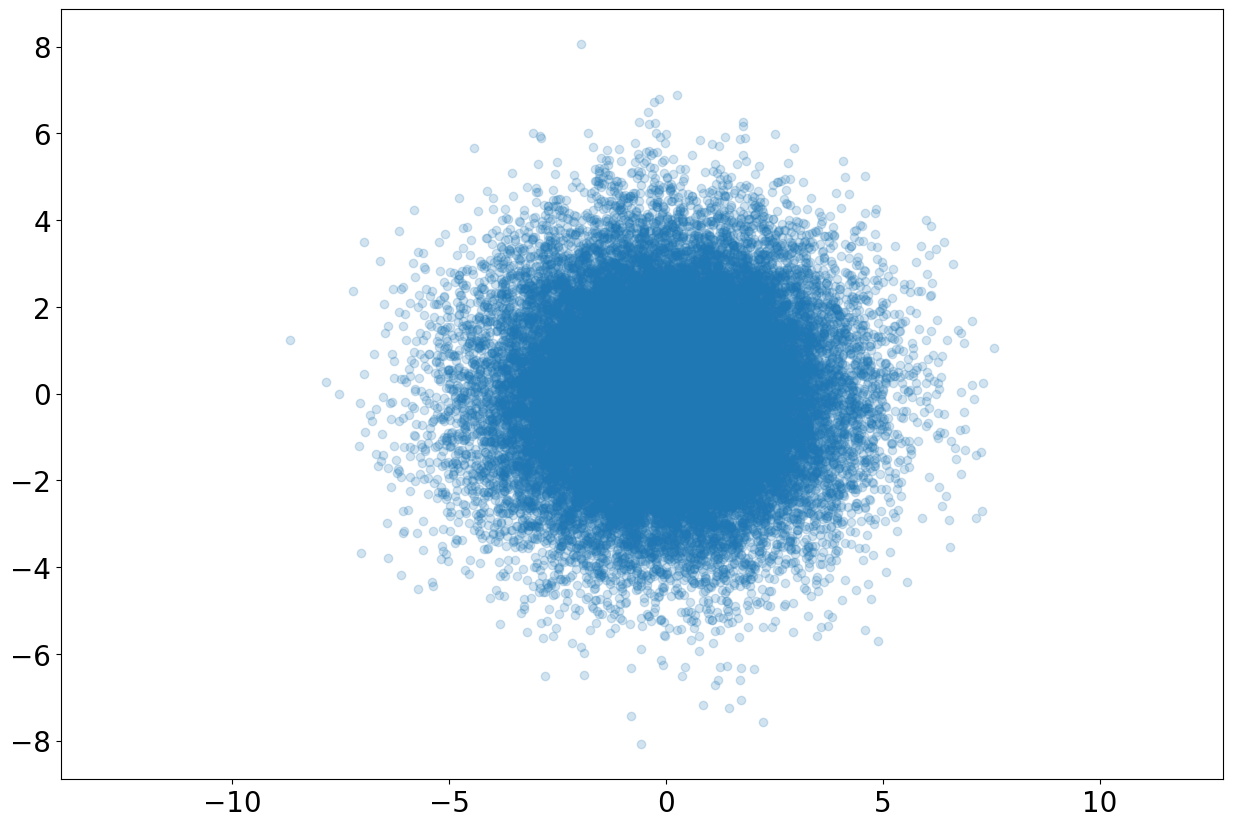

99
Repley's K:  (429.12335290869584, 1.5618200117115038)


<Figure size 1920x1440 with 0 Axes>

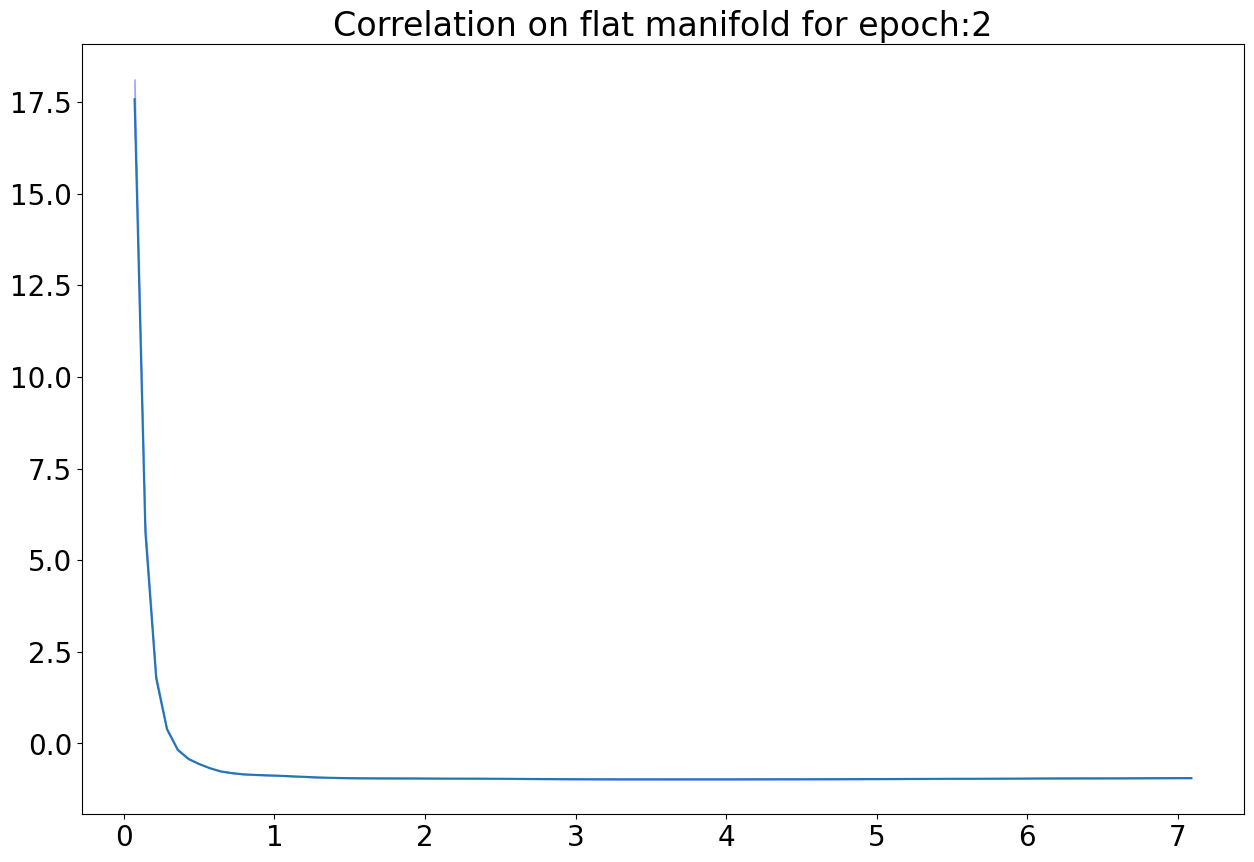

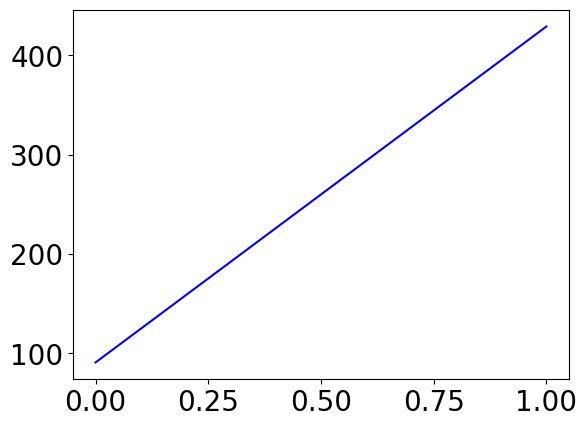

8.846213388493231
Computing background and RR distributions: will be slower


<Figure size 1920x1440 with 0 Axes>

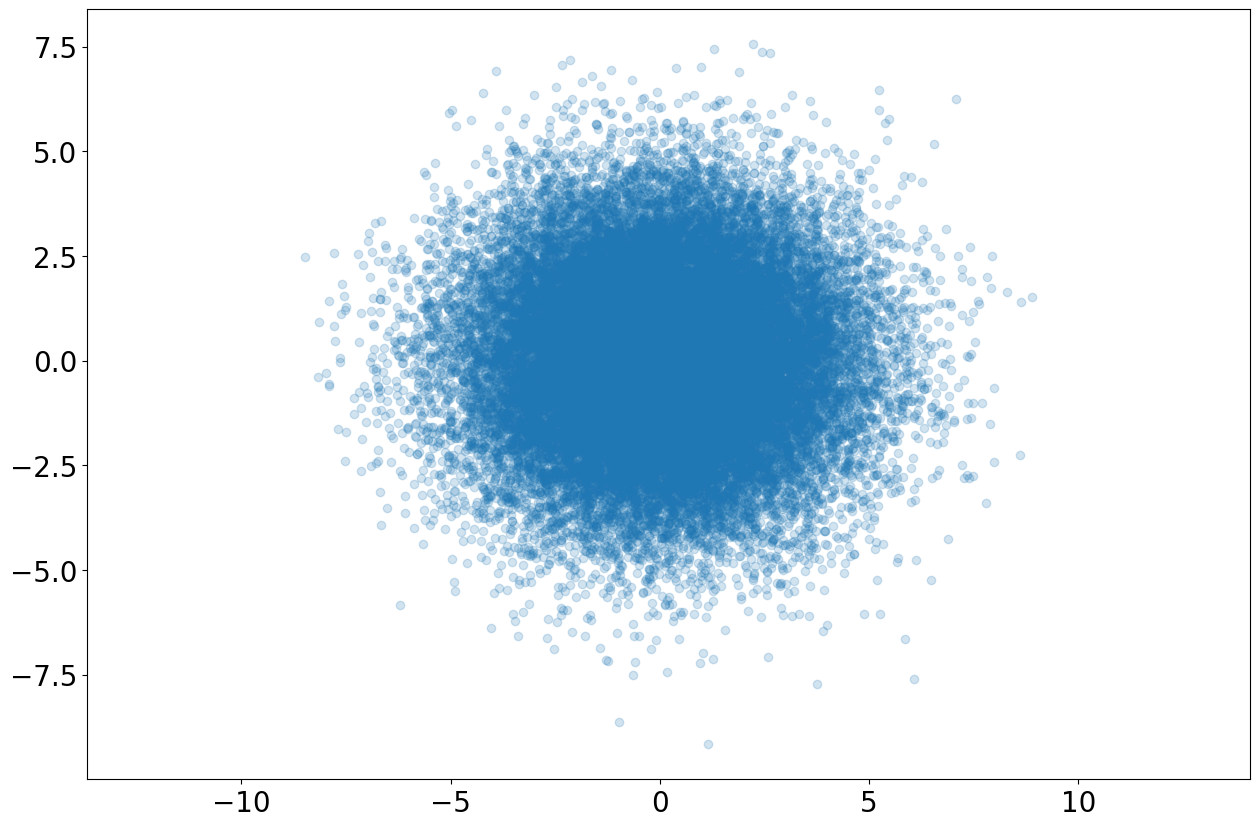

In [ ]:
import importlib
import backbone.AstroMLmodified as AstroMLmod
import pickle
import matplotlib.pyplot as plt
import backbone.VISUAL as viz
importlib.reload(AstroMLmod)

norm_scores = []
#precomputed = AstroMLmod.precompute_gaussian_RR(dimension = 3,n_points =50000)

#plt.plot(precomputed)
#plt.show()

for epoch in range(1,70):
    
    pkl_filename = "plots/val_3d"+str(epoch)+".csv"
    with open(pkl_filename, 'rb') as file:
        val_flat= pickle.load(file)

    #viz.shade(val_flat, predictions = [0]*len(val_flat))
    a,b, norm_score = AstroMLmod.correlate_and_plot(val_flat,
                                                          min_dist = 0.0,
                                                          max_dist =1.5,
                                                          label = "Correlation on flat manifold for epoch:"+str(epoch),
                                                          fig_name = "plots/2PCR@Epoch: "+str(epoch),
                                                          precomputed_RR = None,
                                                          plot = True,
                              
                                                          representations = [])

    

    norm_scores.append(norm_score)

    
    plt.plot([a for a,b in norm_scores], label = "Chi score", color = "blue")
    plt.show()

In [5]:
import backbone.AstroMLmod as AstroMLmod

AstroMLmod.two_point(data,
                      bins,
                      method='standard',
                      errors = "poisson",
                      counts_RR = None,
                      random_state=42, 
                      metric = "euclidean",
                      precomputed_RR = None)




NameError: name 'data' is not defined

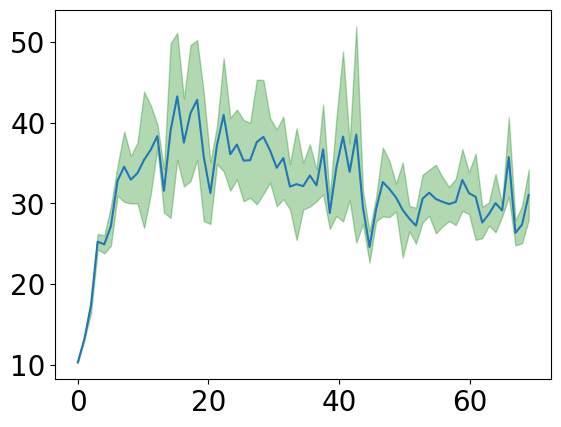

In [34]:
import numpy as np

epochs = np.linspace(0,len(norm_scores),len(norm_scores))

plt.plot(epochs,[a for a,b in norm_scores], label='K_100')
plt.fill_between(epochs,[a-b/50 for a,b in norm_scores],[a+b/50 for a,b in norm_scores], color='green',alpha = 0.3)
plt.show()


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 10))


pkl_filename = "chi_scores.csv"

with open(pkl_filename, 'rb') as file:
    chi_scores = pickle.load(file)

    
pkl_filename = "davies_norm_scores.csv"

with open(pkl_filename, 'rb') as file:
    norm_scores = pickle.load(file)

                
    pkl_filename = "davies_chi_validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_scores = pickle.load(file)
                
pkl_filename = "davies_chi_train.csv"

with open(pkl_filename, 'rb') as file:
    train_scores = pickle.load(file)


epochs = np.linspace(0,len(train_scores),len(train_scores))
# Plot each dataset on its own subplot
#axs[0].plot(chi_scores, color='blue', label='Chi-square')
#axs[0].set_ylabel('Chi-square')
#axs[0].legend()

plt.title("K_100 with sub-sumpling error using uniform background (5X)")

axs[1].plot(epochs,[a for a,b in norm_scores], label='K_100')
axs[1].fill_between(epochs,[a-b/2 for a,b in norm_scores],[a+b/2 for a,b in norm_scores], color='green',alpha = 0.3)

axs[1].set_ylabel('K_100')
axs[1].legend()

axs[2].plot([100-a for a in train_scores], label='Train error')
axs[2].plot([100-a for a in validation_scores], label='Validation error')
axs[2].set_ylabel('Error')
axs[2].set_xlabel('x')
axs[2].legend


# Add a global title
#fig.suptitle('Stacked Subplots with Shared X-axis', fontsize=16)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

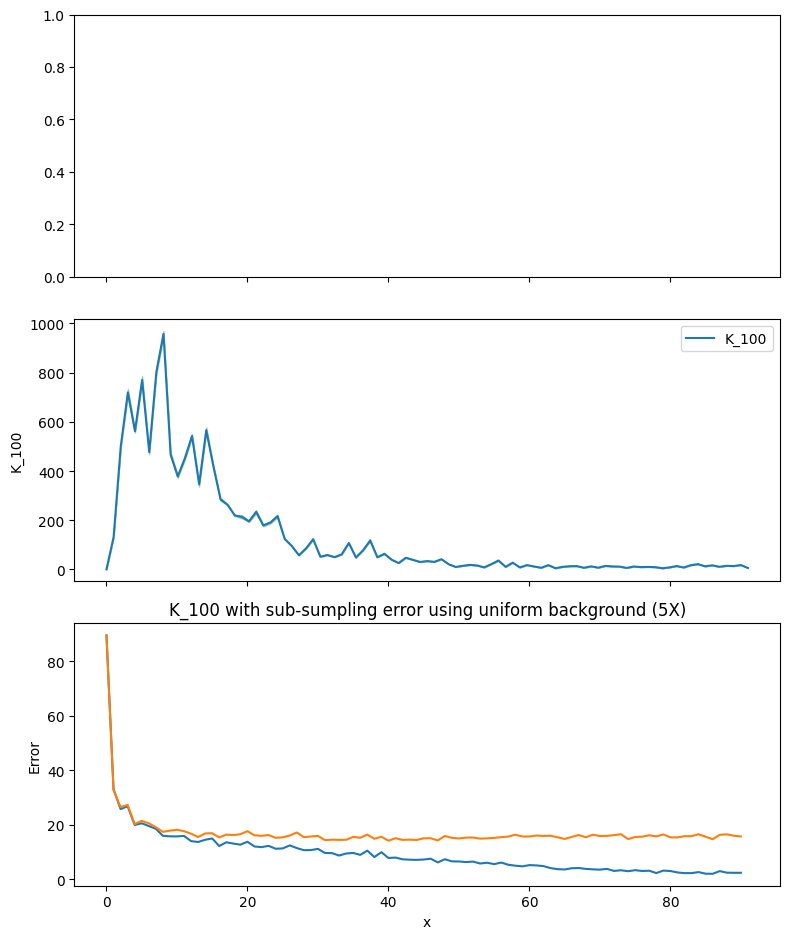

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 13})
fig = plt.figure(dpi = 300)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))



pkl_filename = "bad_norm_scores.csv"

with open(pkl_filename, 'rb') as file:
    chi_scores = pickle.load(file)[0:70]
    
pkl_filename = "norm_scores.csv"

with open(pkl_filename, 'rb') as file:
    norm_scores = pickle.load(file)[0:70]

                
    pkl_filename = "chi_validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_scores = pickle.load(file)[0:70]
                
pkl_filename = "chi_train.csv"

with open(pkl_filename, 'rb') as file:
    train_scores = pickle.load(file)[0:70]


                
    pkl_filename = "bad_chi_validation.csv"
with open(pkl_filename, 'rb') as file:
    bad_validation_scores = pickle.load(file)[0:70]
                
pkl_filename = "bad_chi_train.csv"

with open(pkl_filename, 'rb') as file:
    bad_train_scores = pickle.load(file)[0:70]


epochs = np.linspace(0,len(train_scores),len(train_scores))[0:70]
# Plot each dataset on its own subplot
#axs[0].plot(chi_scores, color='blue', label='Chi-square')
#axs[0].set_ylabel('Chi-square')
#axs[0].legend()

#plt.title("K_100 with sub-sumpling error using uniform background (5X)")

axs[1].plot(epochs,[a for a,b in norm_scores], color = 'orange',label='Structure quantity')
axs[1].fill_between(epochs,[a-b/2 for a,b in norm_scores],[a+b/2 for a,b in norm_scores], color='orange',alpha = 0.3)

axs[1].plot(epochs,[a for a,b in chi_scores],linestyle='--',color = 'red', label='Structure quantity (noisy labels)')
axs[1].fill_between(epochs,[a-b/2 for a,b in norm_scores],[a+b/2 for a,b in norm_scores], color='red',alpha = 0.3)



axs[1].set_ylabel('Structure quantity')
axs[1].legend()

axs[0].plot([100-a for a in train_scores], label='Train error')
axs[0].plot([100-a for a in validation_scores], label='Validation error')

axs[0].plot([100-a for a in bad_train_scores], linestyle='--', label='Train error (noisy labels)')
axs[0].plot([100-a for a in bad_validation_scores], linestyle='--',label='Validation error (noisy labels)')
axs[0].set_ylabel('Error')
axs[0].set_xlabel('x')
axs[0].legend()

# Add a global title
#fig.suptitle('Stacked Subplots with Shared X-axis', fontsize=16)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

In [ ]:
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.scatter(y[1:],[(100-a) for a in validation_accuracy][1:], s = 10)
plt.xlabel("ID score")
plt.ylabel("Validation error")
plt.show()

In [8]:
a = 1000
for i in range(365):
    a +=a*0.001
    a +=1000
100*365-a

-405191.5647430078

In [ ]:
import random


# Example usage
original_list = list(range(10000))
perturbed_list = perturb_list_by_swapping(original_list)


sum(int(a==b) for a,b in zip(original_list,perturbed_list))

In [ ]:
import random
a = np.array([np.array([1231])])
indices = random.sample(range(1),int(1))
indices
a[indices]

In [ ]:

from sklearn.neighbors import KDTree

counts_DD = KDT_D.two_point_correlation(data, bins)